In [1]:
import numpy as np
import pymultinest

import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

import json

import corner

import retrieval_base.auxiliary_functions as af

def read_results(prefix, n_params, w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+'data/bestfit_PT.pkl')
    Chem = af.pickle_load(prefix+'data/bestfit_Chem.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{w_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{w_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{w_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{w_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{w_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{w_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    print(posterior.shape)
    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

In [2]:
#prefix = './retrieval_outputs/fiducial_K_B_ret_9/test_'
#w_set = 'K2166'
#n_params = 28

#prefix = './retrieval_outputs/fiducial_K_B_ret_18/test_'
#w_set = 'K2166'
#n_params = 28

#prefix = './retrieval_outputs/fiducial_K_B_ret_22/test_'
#w_set = 'K2166'
#n_params = 28

#prefix = './retrieval_outputs/fiducial_K_B_ret_23/test_'
#w_set = 'K2166'
#n_params = 28

#prefix = './retrieval_outputs/fiducial_K_B_ret_29/test_'
#w_set = 'K2166'
#n_params = 24

#prefix = './retrieval_outputs/fiducial_K_B_ret_31/test_'
#w_set = 'K2166'
#n_params = 24

prefix = './retrieval_outputs/fiducial_K_B_ret_32/test_'
w_set = 'K2166'
n_params = 25

res = read_results(prefix=prefix, n_params=n_params, w_set=w_set)
posterior, bestfit, PT, Chem, _, _, _, m_spec, d_spec, LogLike, Cov, bestfit_params = res
del res

  analysing data from ./retrieval_outputs/fiducial_K_B_ret_32/test_.txt
(1968, 25)


In [3]:
import copy
from tqdm import tqdm
import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d

def get_pRT_atm(prefix, w_set, bestfit_params, Chem, PT, vsini_local=1):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{w_set}.pkl')

    print(pRT_atm.atm[0].w_gauss, pRT_atm.atm[0].w_gauss_mu, pRT_atm.atm[0].mu)
    #for i in range(len(pRT_atm.atm)):
    #    pRT_atm.atm[i].w_gauss_mu = np.array([1])
    #    pRT_atm.atm[i].mu = np.array([0.5])
    #print(pRT_atm.atm[0].w_gauss, pRT_atm.atm[0].w_gauss_mu, pRT_atm.atm[0].mu)

    # Compute global model spectrum
    params_global = bestfit_params['params'].copy()
    params_global['epsilon_lat'] = None
    
    #params_global['lat_band']     = 0
    #params_global['sigma_band']   = 10
    #params_global['epsilon_band'] = 0.5

    #params_global['alpha_diff_rot'] = 0.8

    pRT_atm.params = params_global

    m_spec_global = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
    m_spec_global.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_global.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    Rot = copy.copy(pRT_atm.Rot)

    # Compute local model spectrum
    params_local = params_global.copy()
    params_local['vsini'] = vsini_local
    #params_local['epsilon_limb'] = 0
    #params_local['epsilon_lat'] = 0
    #params_local['dif_rot_delta'] = 0
    #params_local['dif_rot_phi'] = 1
    pRT_atm.params = params_local

    # Local abundances
    mf_local = Chem.mass_fractions.copy()
    for key_i in mf_local.keys():
        break
    
        if key_i != 'H2O_pokazatel_main_iso':
            mf_local[key_i] *= 0
        #if key_i != 'CH4_hargreaves_main_iso':
        #    mf_local[key_i] *= 0
        #if key_i != 'CO_main_iso':
        #    mf_local[key_i] *= 0

    #print(mf_local)
    #mf_local['CH4_hargreaves_main_iso'] *= 0
    #mf_local['H2O_pokazatel_main_iso'] *= 0

    m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
    m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec_global, m_spec_local, Rot

def get_CCF(
        d_spec, m_spec_local, m_spec_global, LogLike, Cov, rv=np.arange(-1000,1000+1e-6,1)
        ):
    
    CCF = np.nan * np.ones(
        (len(rv), d_spec.n_orders, d_spec.n_dets)
        )
    
    d_wave = d_spec.wave
    d_res = d_spec.flux - LogLike.f[:,:,None]*m_spec_global.flux
    
    # Apply high-pass filter to the residuals
    mask = d_spec.mask_isfinite

    lp_d_res = np.nan*np.ones_like(d_res)
    lp_d_res[mask] = gaussian_filter1d(
        d_res[mask], sigma=300, axis=-1, mode='reflect'
        )
    d_res -= lp_d_res

    for i, rv_i in enumerate(tqdm(rv)):

        for j in range(d_spec.n_orders):
            
            # Shift the model spectrum
            m_wave_local = np.copy(m_spec_local.wave_pRT_grid[j])
            m_wave_local *= (1 + rv_i/(nc.c*1e-5))

            m_flux_local = np.copy(m_spec_local.flux_pRT_grid[j])

            for k in range(d_spec.n_dets):

                # Subtract the global model?
                #m_res_local_jk = LogLike.f[j,k] * (m_flux_local)# - m_spec_global.flux_pRT_grid[j])
                m_res_local_jk = LogLike.f[j,k] * (m_flux_local - m_spec_global.flux_pRT_grid[j])
                
                # Optimal scaling
                #m_res_local *= LogLike.f[j,:][:,None]
                
                # Don't consider the nans
                mask_jk = d_spec.mask_isfinite[j,k]

                if not mask_jk.any():
                    continue

                # Interpolate onto the data wavelength grid
                m_res_local_jk = np.interp(
                    d_wave[j,k], xp=m_wave_local, fp=m_res_local_jk
                    )
                
                #plt.figure(figsize=(15,5))
                #plt.plot(d_wave[j,k], d_res[j,k], c='k', lw=0.5)
                #plt.plot(d_wave[j,k], m_res_local_jk/10, c='C1')
                #plt.show()
                
                lp_m_res_local_jk = np.nan*np.ones_like(m_res_local_jk)
                lp_m_res_local_jk[mask_jk] = gaussian_filter1d(
                    m_res_local_jk[mask_jk], sigma=300, axis=-1, mode='reflect'
                    )
                m_res_local_jk -= lp_m_res_local_jk

                # Compute the covariance-weighted dot-product
                CCF[i,j,k] = np.dot(
                    m_res_local_jk[mask_jk], 1/LogLike.beta[j,k]**2 * Cov[j,k].solve(d_res[j,k,mask_jk])
                    )

    return CCF, rv

In [4]:
m_spec_global, m_spec_local, Rot = get_pRT_atm(prefix, w_set, bestfit_params, Chem, PT, vsini_local=1)

[1.] [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] [1.00000000e+00 9.84807753e-01 9.39692621e-01 8.66025404e-01
 7.66044443e-01 6.42787610e-01 5.00000000e-01 3.42020143e-01
 1.73648178e-01 6.12323400e-17]


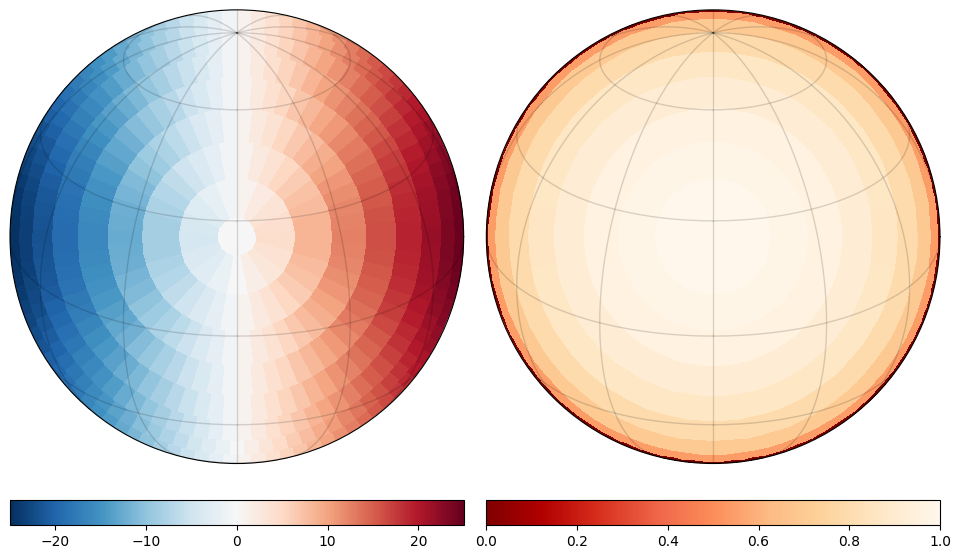

In [16]:
def orthographic_to_xy(lat, lon, lat_0, lon_0, R=1):

    x = R * np.cos(lat) * np.sin(lon-lon_0)
    y = R * (np.cos(lat_0)*np.sin(lat) - np.sin(lat_0)*np.cos(lat)*np.cos(lon-lon_0))

    c = np.arccos(
        np.sin(lat_0)*np.sin(lat) + np.cos(lat_0)*np.cos(lat)*np.cos(lon-lon_0)
    )

    mask = (c > -np.pi/2) & (c < np.pi/2)
    x[~mask] = np.nan
    y[~mask] = np.nan
    return x, y, c

def plot_grid(ax, lat_grid=np.arange(-90,90+1e-6,30), lon_grid=np.arange(0,360,30), inclination=26, lon_0=0, **kwargs):

    lat = np.deg2rad(np.linspace(-90,90,100))
    lon = np.deg2rad(np.linspace(0,360,100))

    inclination = np.deg2rad(inclination)
    lon_0 = np.deg2rad(lon_0)

    for lat_i in np.deg2rad(lat_grid):

        # Orthographic projection
        x, y, c = orthographic_to_xy(lat_i, lon, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

    for lon_i in np.deg2rad(lon_grid):
        
        # Orthographic projection
        x, y, c = orthographic_to_xy(lat, lon_i, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

def plot_map(ax, attr, Rot, cax=None, **kwargs):

    z = getattr(Rot, attr)

    for i, r_i in enumerate(Rot.unique_r):
        th_i = Rot.theta_grid[Rot.r_grid==r_i]
        z_i  = z[Rot.r_grid==r_i]
        r_i  = np.array([r_i])

        th_i = np.concatenate((th_i-th_i.min(), [2*np.pi]))

        dr_p, dr_m = 0, 0
        if i < len(Rot.unique_r)-1:
            dr_p = Rot.unique_r[i+1] - Rot.unique_r[i]
        if i > 0:
            dr_m = Rot.unique_r[i] - Rot.unique_r[i-1]

        r_i = np.array([r_i[0]-dr_m/2, r_i[0]+dr_p])

        if i == 0 or i == len(Rot.unique_r)-1:
            th_i = np.linspace(0,2*np.pi,200)
            z_i = np.repeat(z_i, repeats=len(th_i)-1, axis=0)

        if attr == 'v_grid' and i == len(Rot.unique_r)-1:
            z_i *= np.nan

        zz_shape = (len(r_i)-1,len(th_i)-1)

        tt, rr = np.meshgrid(th_i, r_i)
        zz = z_i.reshape(zz_shape)

        #ax.plot(0, Rot.unique_r[i], 'k.')
        cntr = ax.pcolormesh(np.pi/2-tt, rr, zz, shading='auto', **kwargs)

    if cax is not None:
        import matplotlib as mpl

        norm = mpl.colors.Normalize(vmin=kwargs.get('vmin'), vmax=kwargs.get('vmax'))
        plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=kwargs.get('cmap')), 
            ax=ax, cax=cax, orientation='horizontal'
            )

#for lon_0 in np.arange(0,180,2):
lon_0 = 0

fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(
    nrows=2, ncols=2, hspace=0.05, wspace=0.05,
    height_ratios=[1,0.05], width_ratios=[1,1], 
    )

ax  = np.array([fig.add_subplot(gs[0,0],projection='polar'),fig.add_subplot(gs[0,1],projection='polar')])
cax = np.array([fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])])

for i, ax_i in enumerate(ax.flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_ylim(0,1)
    #ax_i.axis('off')

    plot_grid(ax_i, lon_0=lon_0, c='k', alpha=0.15, lw=1)

plot_map(ax[0], 'v_grid', Rot, cax=cax[0], cmap='RdBu_r', vmin=-25, vmax=25)
plot_map(ax[1], 'f_grid', Rot, cax=cax[1], cmap='OrRd_r', vmin=0, vmax=Rot.f_grid.max())
plt.show()

In [6]:
CCF, rv = get_CCF(
    d_spec, m_spec_local, m_spec_global, LogLike, Cov, rv=np.arange(-200,200+1e-6,1)
    #rv=[0]
    )

100%|██████████| 401/401 [00:15<00:00, 26.05it/s]


-5.0
25.05727584754826


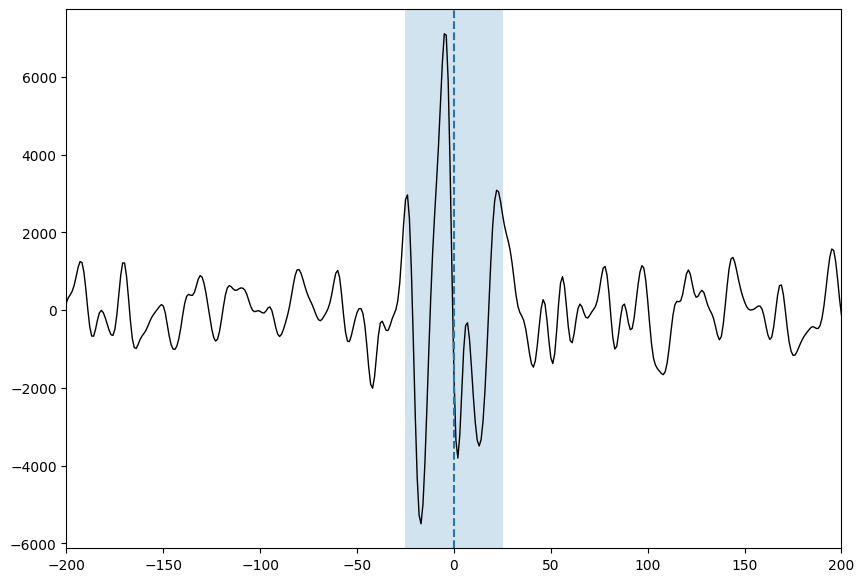

In [7]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(rv, np.nansum(CCF, axis=(1,2)), c='k', lw=1)

#idx = np.argmax(CCF.sum(axis=(1,2)))
#ax.axvline(rv[idx], c='k', ls='-', lw=1)
print(rv[np.argmax(np.nansum(CCF, axis=(1,2)))])
print(bestfit_params['params']['vsini'])

ax.axvline(0, c='C0', ls='--')
ax.axvspan(
    xmin=-bestfit_params['params']['vsini'], 
    xmax=bestfit_params['params']['vsini'], 
    fc='C0', ec='none', alpha=0.2
    )

ax.set(xlim=(-200,200))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(rv, CCF.sum(axis=(1,2)), c='k', lw=1)

#idx = np.argmax(CCF.sum(axis=(1,2)))
#ax.axvline(rv[idx], c='k', ls='-', lw=1)
print(rv[np.argmax(np.nansum(CCF, axis=(1,2)))])

ax.axvline(0, c='C0', ls='--')
ax.axvspan(
    xmin=-bestfit_params['params']['vsini'], 
    xmax=bestfit_params['params']['vsini'], 
    fc='C0', ec='none', alpha=0.2
    )

ax.set(xlim=(-200,200))
plt.show()

In [ ]:
for i in range(d_spec.n_orders):

    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(rv, np.nansum(CCF[:,i,:], axis=1), c='k', lw=1)

    idx = np.argmax(CCF[:,i,:].sum(axis=1))
    ax.axvline(rv[idx], c='k', ls='-', lw=1)
    print(rv[idx])

    ax.axvline(0, c='C0', ls='--')
    ax.axvspan(
        xmin=-bestfit_params['params']['vsini'], 
        xmax=bestfit_params['params']['vsini'], 
        fc='C0', ec='none', alpha=0.2
        )

    ax.set(xlim=(-200,200))
    plt.show()